## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [63]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from itertools import chain
import sklearn.model_selection as skl
import scipy
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from random import sample 
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix


##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [64]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(10)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
38241,00010007_160.png,Infiltration,160,10007,59,M,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010007_160.png
61524,00015188_000.png,No Finding,0,15188,30,F,PA,2614,2991,0.143,0.143,NaN,/data/images_007/images/00015188_000.png
9007,00002361_000.png,Pleural_Thickening,0,2361,50,F,PA,2048,2500,0.171,0.171,NaN,/data/images_002/images/00002361_000.png
43611,00011237_075.png,No Finding,75,11237,56,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00011237_075.png
79821,00019608_000.png,Pleural_Thickening,0,19608,64,M,PA,3056,2544,0.139,0.139,NaN,/data/images_009/images/00019608_000.png
63674,00015714_001.png,No Finding,1,15714,26,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00015714_001.png
37655,00009912_000.png,No Finding,0,9912,36,M,AP,3056,2544,0.139,0.139,NaN,/data/images_005/images/00009912_000.png
6489,00001738_004.png,No Finding,4,1738,46,M,PA,2048,2500,0.171,0.171,NaN,/data/images_002/images/00001738_004.png
90411,00022487_001.png,Atelectasis,1,22487,71,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00022487_001.png
95296,00025008_000.png,No Finding,0,25008,23,M,PA,2544,3056,0.139,0.139,NaN,/data/images_011/images/00025008_000.png


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  path                         112120 non-null  object 
dtyp

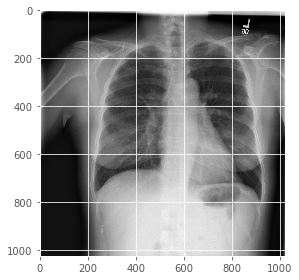

In [65]:

check= imread("/data/images_007/images/00015700_002.png")
imshow(check)
print (all_xray_df.info())

In [66]:
All_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
All_labels = [x for x in All_labels if len(x)>0]
for c_label in All_labels:
    if len(c_label)>1: 
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0,0,1,0,0,0,0,0,0,0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0,0,1,1,0,0,0,0,0,0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


[Text(0, 0.5, 'Number of Images with Label')]

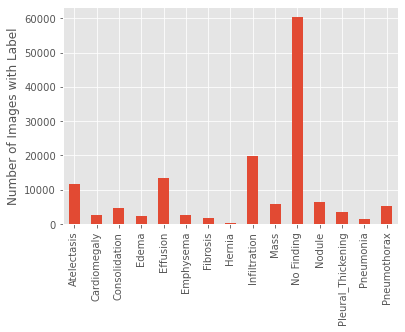

In [67]:
#Distribution of diseases
ax = all_xray_df[All_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

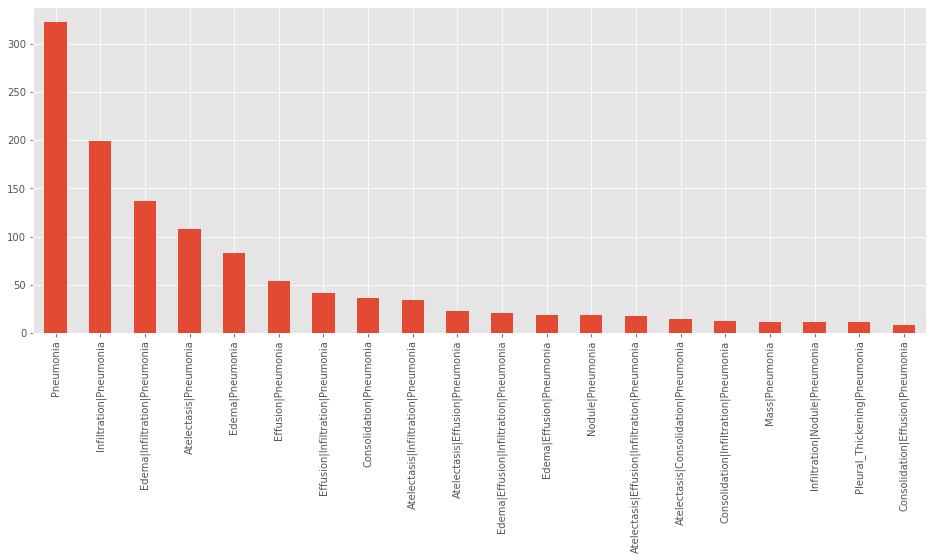

In [68]:
#20 most common co_occurence
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')

In [69]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df.rename(columns={'Pneumonia':'Pneumonia_class'}, inplace=True)
all_xray_df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia_class,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [70]:
all_xray_df['Pneumonia_class']=all_xray_df['Pneumonia_class'].replace({1:'pneumonia',0:'non_pneumonia'})
all_xray_df.sample(20)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia_class,Pneumothorax
26913,00007029_000.png,Atelectasis,0,7029,25,M,PA,2500,2048,0.171000,...,0,0,0,0,0,0,0,0,non_pneumonia,0
53192,00013430_001.png,Atelectasis|Infiltration,1,13430,25,M,AP,3056,2544,0.139000,...,0,0,0,1,0,0,0,0,non_pneumonia,0
4691,00001255_019.png,Consolidation,19,1255,13,M,AP,2500,2048,0.171000,...,0,0,0,0,0,0,0,0,non_pneumonia,0
12991,00003393_015.png,Nodule,15,3393,58,M,AP,2500,2048,0.171000,...,0,0,0,0,0,0,1,0,non_pneumonia,0
9132,00002387_002.png,No Finding,2,2387,56,F,PA,1840,2021,0.194311,...,0,0,0,0,0,1,0,0,non_pneumonia,0
76003,00018642_006.png,No Finding,6,18642,58,M,PA,3056,2544,0.139000,...,0,0,0,0,0,1,0,0,non_pneumonia,0
28188,00007343_000.png,No Finding,0,7343,25,M,AP,2500,2048,0.171000,...,0,0,0,0,0,1,0,0,non_pneumonia,0
69645,00017158_025.png,No Finding,25,17158,58,M,PA,2990,2991,0.143000,...,0,0,0,0,0,1,0,0,non_pneumonia,0
39109,00010245_000.png,No Finding,0,10245,30,F,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,non_pneumonia,0
60684,00014981_000.png,Nodule,0,14981,32,M,PA,2992,2991,0.143000,...,0,0,0,0,0,0,1,0,non_pneumonia,0


## Create your training and testing data:

In [71]:
def create_splits(df):
    #creating appropraite training and validation data
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df['Pneumonia_class'])
   #ensuring equal proportions of pneumonia and non pneumonia cases in train data
    pneumonia_inds = train_data[train_data["Pneumonia_class"]=="pneumonia"].index.tolist()
    non_pneumonia_inds = train_data[train_data["Pneumonia_class"]=="non_pneumonia"].index.tolist()

    non_pneumonia_sample = sample(non_pneumonia_inds,len(pneumonia_inds))
    train_data = train_data.loc[pneumonia_inds + non_pneumonia_sample]
    #balance validation data
    pneumonia_inds = val_data[val_data["Pneumonia_class"]=="pneumonia"].index.tolist()
    non_pneumonia_inds = val_data[val_data["Pneumonia_class"]=="non_pneumonia"].index.tolist()
    non_pneumonia_sample = sample(non_pneumonia_inds,4*len(pneumonia_inds))
    val_data = val_data.loc[pneumonia_inds + non_pneumonia_sample]
    
    return train_data, val_data

In [72]:
train_data, val_data=create_splits(all_xray_df)

In [73]:
train_data.shape

(2290, 28)

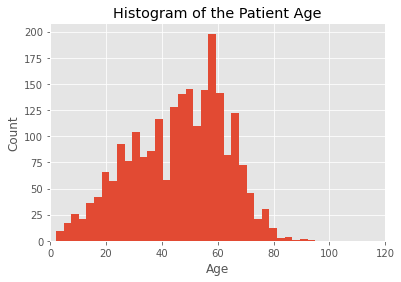

In [74]:
plt.hist(train_data['Patient Age'],bins=150);
plt.xlim(0,120);
plt.title('Histogram of the Patient Age')
plt.xlabel('Age')
plt.ylabel('Count');

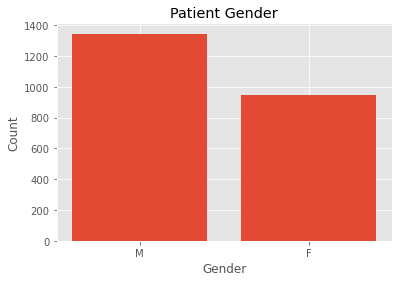

In [75]:
Gender=train_data['Patient Gender'].value_counts()
plt.bar(Gender.index, Gender);
plt.title('Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count');

In [76]:
val_data.shape

(1430, 28)

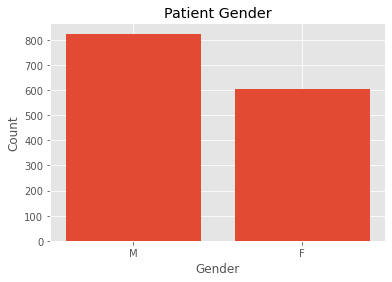

In [77]:
Gender=val_data['Patient Gender'].value_counts()
plt.bar(Gender.index, Gender);
plt.title('Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count');

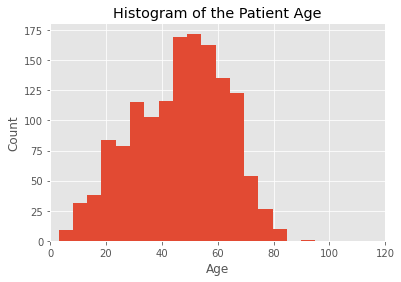

In [78]:

plt.hist(val_data['Patient Age'],bins=80);
plt.xlim(0,120);
plt.title('Histogram of the Patient Age')
plt.xlabel('Age')
plt.ylabel('Count');

In [79]:
train_data.query('Pneumonia_class=="pneumonia"')['Pneumonia_class'].count()/len(train_data)

0.5

In [80]:
val_data.query('Pneumonia_class=="pneumonia"')['Pneumonia_class'].count()/len(val_data)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [81]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.6, 
                              width_shift_range=0.4, 
                              rotation_range=45, 
                              shear_range = 0.1,
                              zoom_range=0.1
                                   )
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
   
    return my_train_idg,my_val_idg
    
    return my_idg


def make_train_gen(my_train_idg,train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
      train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'Pneumonia_class' ,
                                          class_mode = 'binary',
                                          target_size = (224, 224), 
                                          batch_size = 100 
                                          )
    
      return train_gen
    
    

def make_val_gen(my_val_idg,val_df):
    
     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'Pneumonia_class',
                                              class_mode ='binary',
                                              target_size = (224, 224) , 
                                              batch_size = 200) 
    

     return val_gen

In [82]:
## May want to pull a single large batch of random validation data for testing after each epoch:
my_train_idg,my_val_idg=my_image_augmentation()
val_gen=make_val_gen(my_val_idg,val_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.


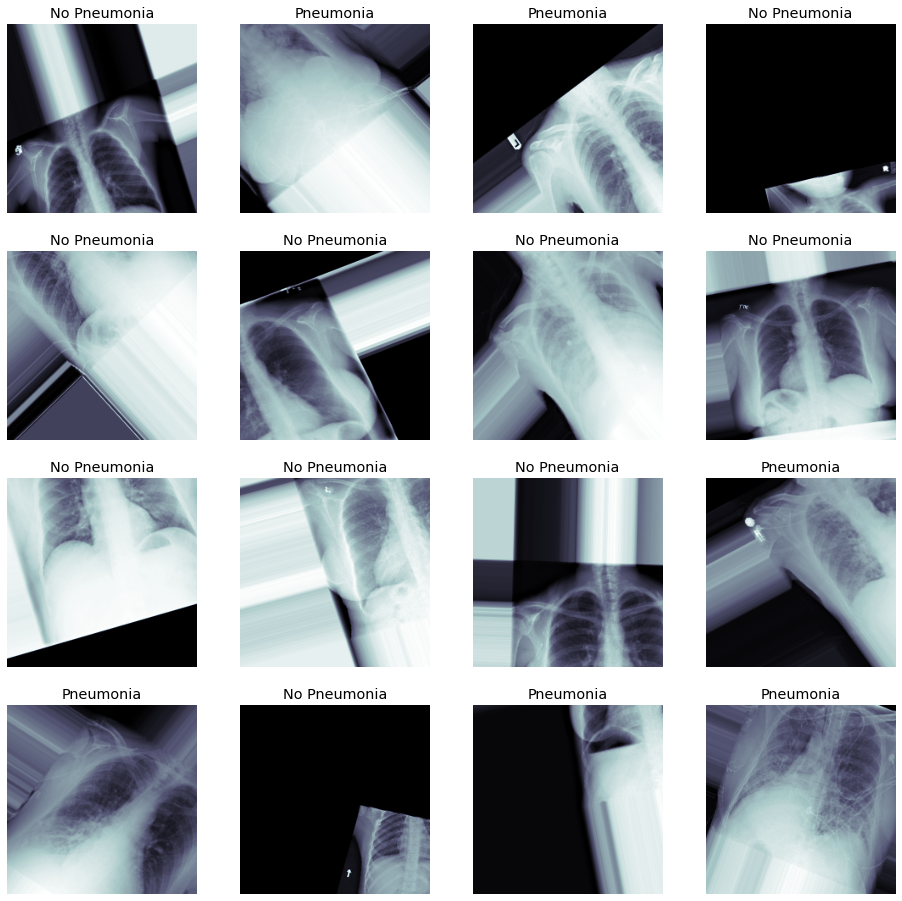

In [83]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
train_gen=make_train_gen(my_train_idg,train_data)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [84]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer("block5_conv1")
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    
    return vgg_model


In [85]:
vgg_model=load_pretrained_model()
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [86]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
     for layer in vgg_model.layers[0:20]:
        layer.trainable = False
        my_model = Sequential()
        my_model.add(vgg_model)
        my_model.add(Flatten())
        my_model.add(Dense(1, activation='sigmoid'))
        optimizer = Adam(lr=1e-4)
        loss = 'binary_crossentropy'
        metrics = ['binary_accuracy']
    
        my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        return my_model




In [87]:
my_model=build_my_model(vgg_model)

In [88]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, 
                              monitor= "val_loss", 
                              verbose=1, 
                              save_best_only=True, 
                              mode= "max", 
                              save_weights_only = True)
early = EarlyStopping(monitor= "val_loss", 
                       mode= "max", 
                       patience=10)
callbacks_list = [checkpoint, early]

### Start training! 

In [89]:


history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10,
                          callbacks = callbacks_list)

Epoch 1/10
23/23 [==============================] - 71s 3s/step - loss: 0.7542 - binary_accuracy: 0.5004 - val_loss: 0.6249 - val_binary_accuracy: 0.7850

Epoch 00001: val_loss improved from -inf to 0.62494, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
23/23 [==============================] - 65s 3s/step - loss: 0.6915 - binary_accuracy: 0.5271 - val_loss: 0.7027 - val_binary_accuracy: 0.5150

Epoch 00002: val_loss improved from 0.62494 to 0.70271, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
23/23 [==============================] - 65s 3s/step - loss: 0.6894 - binary_accuracy: 0.5380 - val_loss: 0.6456 - val_binary_accuracy: 0.6750

Epoch 00003: val_loss did not improve from 0.70271
Epoch 4/10
23/23 [==============================] - 65s 3s/step - loss: 0.6901 - binary_accuracy: 0.5515 - val_loss: 0.6706 - val_binary_accuracy: 0.6350

Epoch 00004: val_loss did not improve from 0.70271
Epoch 5/10
23/23 [==============================] - 65s 3s/step - loss: 0.692

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [101]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
my_model.save('my_model.best.hdf5')

In [102]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

200/200 [==============================] - 2s 9ms/step


In [103]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
def plot_f1t(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1=2*(precision*recall)/(precision+recall)
    c_ax.plot(f1[0:len(thresholds)], thresholds, label = 'f1_score vs threshold')
    c_ax.legend()
    c_ax.set_xlabel('thresholds')
    c_ax.set_ylabel('f1_score')

def  calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)
    
def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

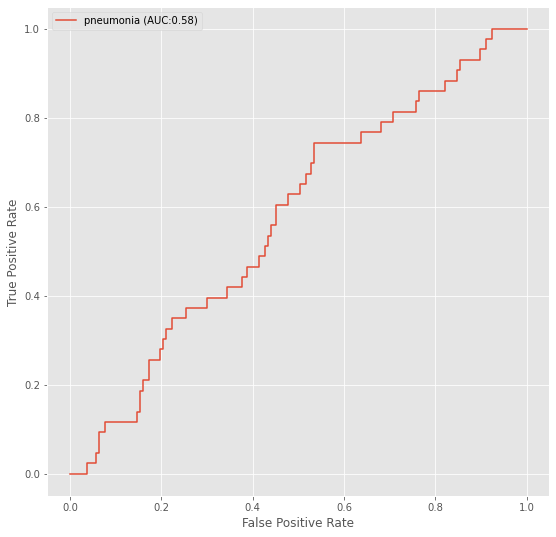

In [104]:
## plot figures
plot_auc(valY, pred_Y)

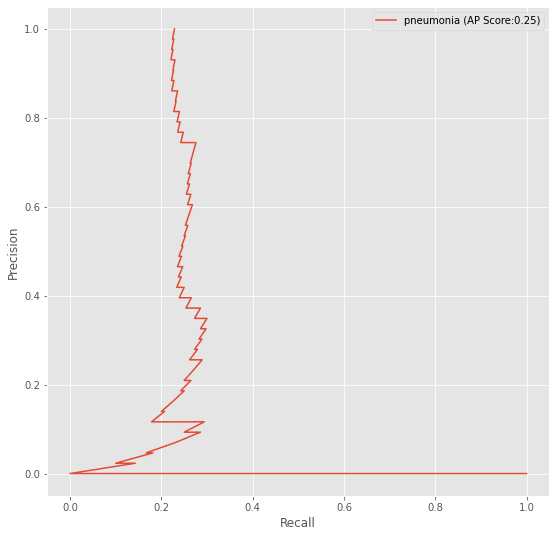

In [105]:
plot_pr(valY, pred_Y)

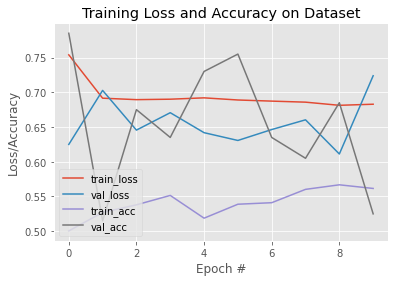

In [106]:

plot_history(history)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


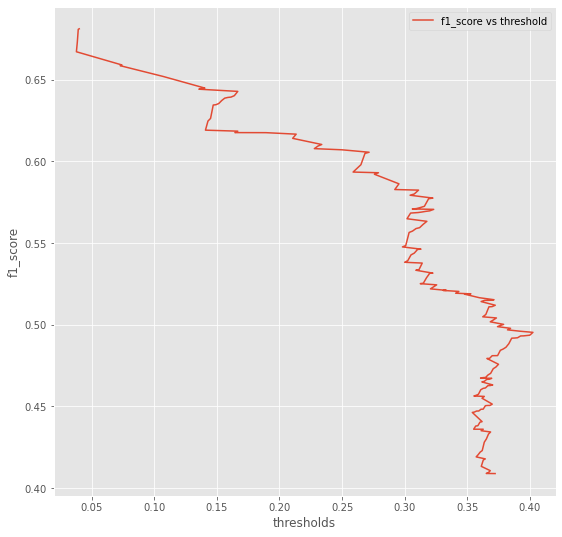

In [107]:
plot_f1t(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [108]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
recall_value = 0.5
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.24444444444444444
Recall is: 0.5116279069767442
Threshold is: 0.52093756
F1 Score is: 0.3308270676691729


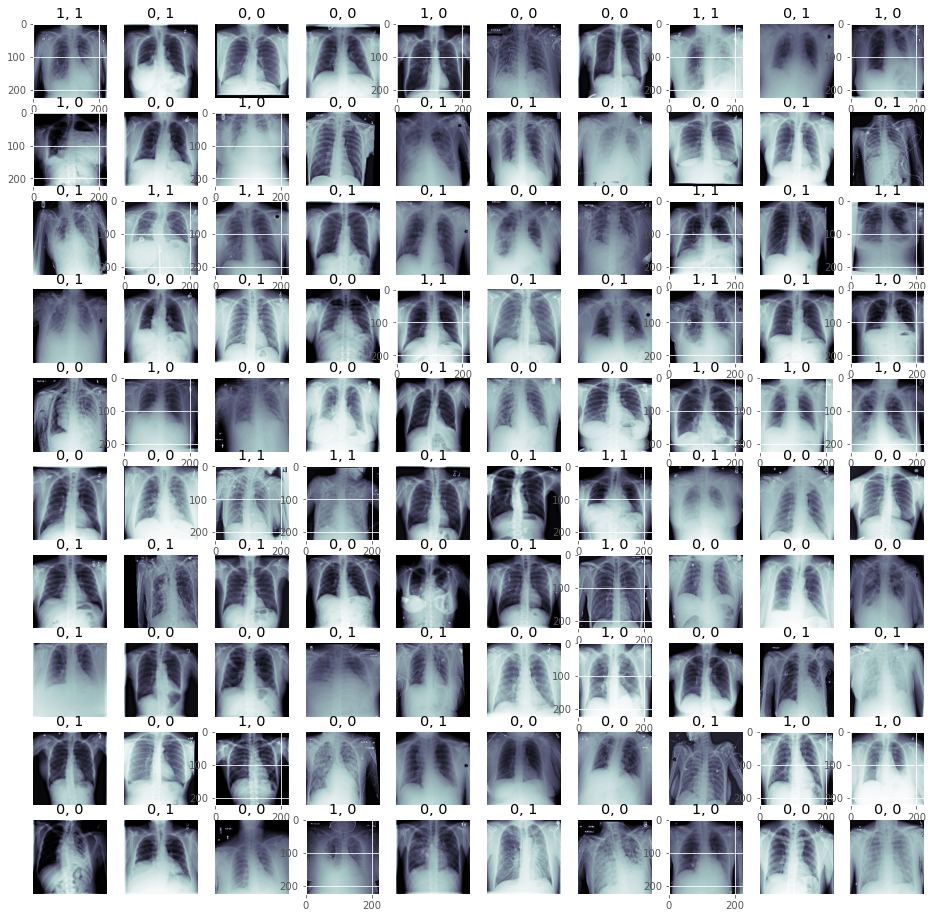

In [109]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
        c_ax.imshow(c_x[:,:,0], cmap = 'bone')
        if c_y == 1: 
            if pred_Y[i] > thresholds[idx]:
                c_ax.set_title('1, 1')
            else:
                c_ax.set_title('1, 0')
        else:
            if pred_Y[i] > thresholds[idx]: 
                c_ax.set_title('0, 1')
            else:
                c_ax.set_title('0, 0')
            c_ax.axis('off')
            i=i+1

In [111]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.best.json", "w") as json_file:
    json_file.write(model_json)